In [10]:
import pandas as pd
df_raw = pd.read_csv("/content/Work Overload Check (Ответы) - Ответы на форму (1).csv")
print("df_raw shape:", df_raw.shape)



df_raw shape: (250, 8)


In [11]:
import pandas as pd
import numpy as np

def find_col(startswith_text):
    for c in df_raw.columns:
        if c.strip().startswith(startswith_text):
            return c
    raise KeyError(f"Column not found: {startswith_text}")

# 1) Select columns from df_raw (fresh every run)
col_q1 = find_col("I struggle to focus on one task without distraction.")
col_q2 = find_col("While working, I notice physical tension")
col_q3 = find_col("I feel mentally exhausted at the end of my workday.")
col_q4 = find_col("Even when tired, I find it hard to stop working.")
col_q5 = find_col("Breaks do not noticeably restore my energy.")
col_q6 = find_col("Overall, my current work stress level is:")

df = df_raw[[col_q1, col_q2, col_q3, col_q4, col_q5, col_q6]].copy()
df.columns = ["Q1","Q2","Q3","Q4","Q5","Q6"]

print("df shape right after selecting:", df.shape)
print(df.head(2))

# 2) Mapping dictionaries
MAP_5LEVEL = {
    "Not at all / Совсем нет": 1,
    "Slightly / Немного": 2,
    "Moderately / Умеренно": 3,
    "Strongly / Сильно": 4,
    "Extremely / Очень сильно": 5,
}

MAP_STRESS_4LEVEL = {
    "Low / Низкий": 1,
    "Moderate / Умеренный": 2,
    "High / Высокий": 3,
    "Critical / Критический": 4,
}

# 3) Apply mapping
for c in ["Q1","Q2","Q3","Q4","Q5"]:
    df[c] = df[c].astype(str).str.strip().map(MAP_5LEVEL)

df["Q6"] = df["Q6"].astype(str).str.strip().map(MAP_STRESS_4LEVEL)

print("\nMissing values per column AFTER conversion:")
print(df.isna().sum())

df_clean = df.dropna()
print("\ndf_clean shape:", df_clean.shape)
print(df_clean.head(3))


df shape right after selecting: (250, 6)
                   Q1                     Q2                       Q3  \
0  Slightly / Немного      Strongly / Сильно  Not at all / Совсем нет   
1  Slightly / Немного  Moderately / Умеренно    Moderately / Умеренно   

                      Q4                       Q5                    Q6  
0  Moderately / Умеренно  Not at all / Совсем нет  Moderate / Умеренный  
1  Moderately / Умеренно    Moderately / Умеренно  Moderate / Умеренный  

Missing values per column AFTER conversion:
Q1    0
Q2    1
Q3    0
Q4    1
Q5    0
Q6    0
dtype: int64

df_clean shape: (248, 6)
   Q1   Q2  Q3   Q4  Q5  Q6
0   2  4.0   1  3.0   1   2
1   2  3.0   3  3.0   3   2
2   3  4.0   4  2.0   1   3


Rows used for correlation: 248
Correlation matrix:
       Q1     Q2     Q3     Q4     Q5     Q6
Q1  1.000  0.522  0.555  0.329  0.442  0.524
Q2  0.522  1.000  0.571  0.528  0.454  0.530
Q3  0.555  0.571  1.000  0.485  0.560  0.642
Q4  0.329  0.528  0.485  1.000  0.416  0.480
Q5  0.442  0.454  0.560  0.416  1.000  0.534
Q6  0.524  0.530  0.642  0.480  0.534  1.000


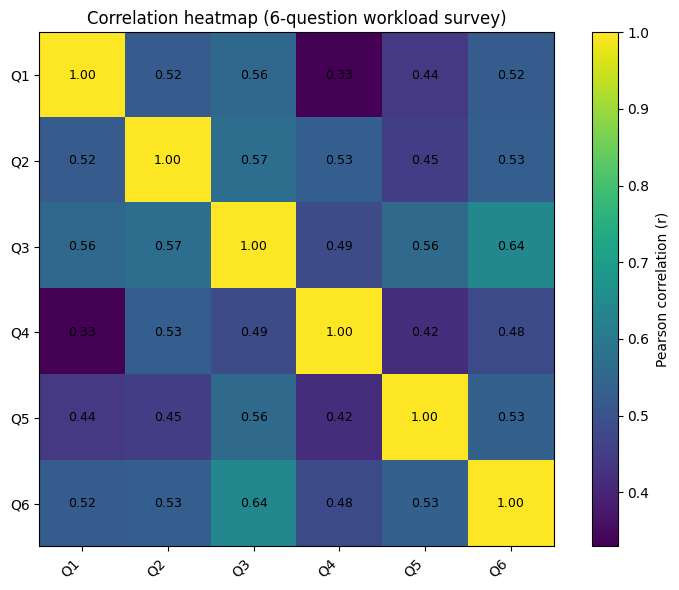

In [12]:
import matplotlib.pyplot as plt

# IMPORTANT: use df_clean that was already converted in Cell B
print("Rows used for correlation:", len(df_clean))

corr = df_clean.corr()
print("Correlation matrix:")
print(corr.round(3))

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(label="Pearson correlation (r)")

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.values[i, j]:.2f}",
                 ha="center", va="center", fontsize=9)

plt.title("Correlation heatmap (6-question workload survey)")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=200)
plt.show()


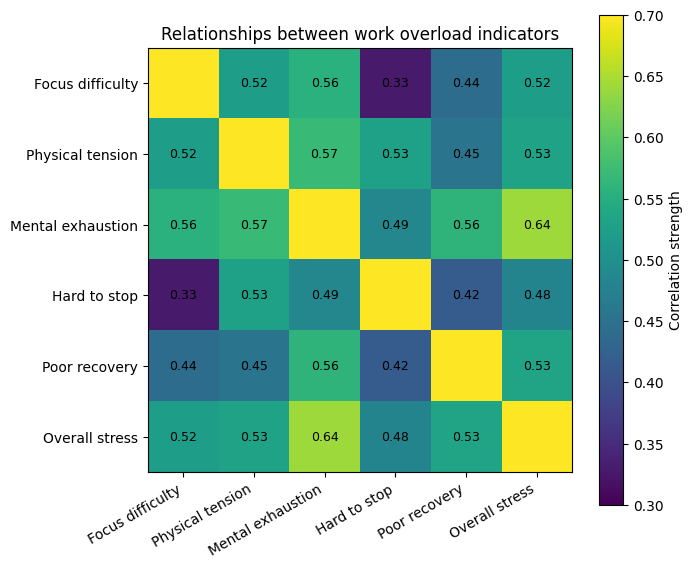

In [13]:
import matplotlib.pyplot as plt
import numpy as np

labels = [
    "Focus difficulty",
    "Physical tension",
    "Mental exhaustion",
    "Hard to stop",
    "Poor recovery",
    "Overall stress"
]

corr = df_clean.corr().values
mask = np.eye(len(corr), dtype=bool)

plt.figure(figsize=(7,6))
im = plt.imshow(corr, vmin=0.3, vmax=0.7)

plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
plt.yticks(range(len(labels)), labels)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if not mask[i, j]:
            plt.text(j, i, f"{corr[i, j]:.2f}",
                     ha="center", va="center", fontsize=9)

plt.colorbar(im, label="Correlation strength")
plt.title("Relationships between work overload indicators")
plt.tight_layout()
plt.savefig("heatmap_clean.png", dpi=200)
plt.show()


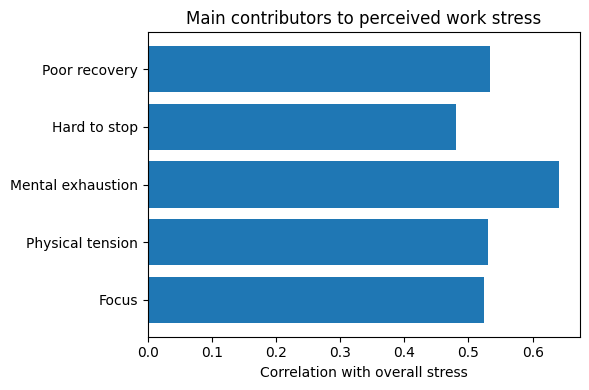

In [14]:
stress_corr = df_clean.corr()["Q6"].drop("Q6")

plt.figure(figsize=(6,4))
plt.barh(
    ["Focus", "Physical tension", "Mental exhaustion",
     "Hard to stop", "Poor recovery"],
    stress_corr.values
)

plt.xlabel("Correlation with overall stress")
plt.title("Main contributors to perceived work stress")
plt.tight_layout()
plt.savefig("stress_drivers.png", dpi=200)
plt.show()


In [15]:
import pandas as pd

# Average values for dashboard
dashboard_df = pd.DataFrame({
    "Indicator": [
        "Focus difficulty",
        "Physical tension",
        "Mental exhaustion",
        "Hard to stop",
        "Poor recovery",
        "Overall stress"
    ],
    "Average score": [
        df_clean["Q1"].mean(),
        df_clean["Q2"].mean(),
        df_clean["Q3"].mean(),
        df_clean["Q4"].mean(),
        df_clean["Q5"].mean(),
        df_clean["Q6"].mean(),
    ]
})

dashboard_df


,Indicator,Average score
0,Focus difficulty,2.754032
1,Physical tension,2.725806
2,Mental exhaustion,2.975806
3,Hard to stop,2.741935
4,Poor recovery,2.790323
5,Overall stress,2.262097


In [16]:
dashboard_df.to_csv("grafana_dashboard.csv", index=False)
print("Saved grafana_dashboard.csv")


Saved grafana_dashboard.csv
